In [139]:
import pandas as pd

In [140]:
races_df = pd.read_csv('races.csv', index_col='race_id')
runs_df = pd.read_csv('runs.csv')

# Set up dataframe

create new dataframe df that we will use to train the model

### Remove unnessussary columns from runs_df

In [141]:
df = runs_df
df=df.drop('won',axis=1)
df=df.drop('horse_gear',axis=1)
df=df.drop('draw',axis=1)

# the below have too many na values
df = df.drop('horse_no', axis = 1)
df=df.drop('position_sec1',axis=1)
df=df.drop('position_sec2',axis=1)
df=df.drop('position_sec3',axis=1)
df=df.drop('position_sec4',axis=1)
df=df.drop('position_sec5',axis=1)
df=df.drop('position_sec6',axis=1)
df=df.drop('behind_sec1',axis=1)
df=df.drop('behind_sec2',axis=1)
df=df.drop('behind_sec3',axis=1)
df=df.drop('behind_sec4',axis=1)
df=df.drop('behind_sec5',axis=1)
df=df.drop('behind_sec6',axis=1)
df=df.drop('time4',axis=1)
df=df.drop('time5',axis=1)
df=df.drop('time6',axis=1)
df=df.drop('place_odds',axis=1) 

### Add relevant columns from races_df

In [142]:
df = pd.merge(df, races_df[['venue','config','surface','distance','going']], on='race_id', how='left')

### Create new columns to add to df

#### time metric columns
these columns use the time1 time2 and time3 fields to determine how much of the final time was used to run different parts of the race

In [143]:
df["time1"] = df["time1"] / df["finish_time"]
df["time2"] = df["time2"] / df["finish_time"]
df["time3"] = df["time3"] / df["finish_time"]
df["time23"] = (df["time2"] + df["time3"]) / df["finish_time"]

#### Add horse, jockey, and trainer placement percentage columns

add columns capturing the likelyhood of a given, horse, jockey, and trainer placing in the race

###### New Horse columns

In [144]:
horse_tot_race=runs_df.groupby(['horse_id'])['result'].apply(lambda x: (x).sum()).reset_index(name='horse_tot_race')

df=pd.merge(df,horse_tot_race,on='horse_id',how='left')

horse_tot_place=runs_df.groupby(['horse_id'])['result'].apply(lambda x: (x <=3).sum()).reset_index(name='horse_tot_place')

df=pd.merge(df,horse_tot_place,on='horse_id',how='left')

df['horse_place_perc']=df['horse_tot_place']/df['horse_tot_race']

###### New Jockey columns

In [145]:
jockey_tot_race=runs_df.groupby(['jockey_id'])['result'].apply(lambda x: (x).sum()).reset_index(name='jockey_tot_race')

df=pd.merge(df,jockey_tot_race,on='jockey_id',how='left')

jockey_tot_place=runs_df.groupby(['jockey_id'])['result'].apply(lambda x: (x <=3).sum()).reset_index(name='jockey_tot_place')

df=pd.merge(df,jockey_tot_place,on='jockey_id',how='left')

df['jockey_place_perc']=df['jockey_tot_place']/df['jockey_tot_race']

###### New Trainer Columns

In [146]:
trainer_tot_race=runs_df.groupby(['trainer_id'])['result'].apply(lambda x: (x).sum()).reset_index(name='trainer_tot_race')

df=pd.merge(df,trainer_tot_race,on='trainer_id',how='left')

trainer_tot_place=runs_df.groupby(['trainer_id'])['result'].apply(lambda x: (x <=3).sum()).reset_index(name='trainer_tot_place')

df=pd.merge(df,trainer_tot_place,on='trainer_id',how='left')

df['trainer_place_perc']=df['trainer_tot_place']/df['trainer_tot_race']

##### Remove unneccessary columns

In [147]:
df=df.drop('horse_tot_place',axis=1)
df=df.drop('horse_tot_race',axis=1)
df=df.drop('horse_id',axis=1)


df=df.drop('trainer_tot_place',axis=1)
df=df.drop('trainer_tot_race',axis=1)
df=df.drop('trainer_id',axis=1)


df=df.drop('jockey_tot_place',axis=1)
df=df.drop('jockey_tot_race',axis=1)
df=df.drop('jockey_id',axis=1)

### Clean the data

In [148]:
# Define Anomalies function
def iqr_anomalies(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

In [ ]:
print("number of rows before cleaning:", df.shape[0])

# drop missing values
df = df.dropna()

# drop duplicates
df = df.drop_duplicates()


# handle anomalies
race_ids = df['race_id'].unique()
anomalie_race_ids = df.iloc[iqr_anomalies(df, "finish_time").index]["race_id"].unique()
anomalie_race_indicies = df[df["race_id"].isin(anomalie_race_ids)].index
df = df.drop(anomalie_race_indicies)

number of rows before cleaning: 79447
number of rows after cleaning: 78755


### Encode categorical variables

In [150]:
from sklearn import preprocessing

config_encoder = preprocessing.OrdinalEncoder()
df['config'] = config_encoder.fit_transform(df['config'].values.reshape(-1, 1))

going_encoder = preprocessing.OrdinalEncoder()
df['going'] = going_encoder.fit_transform(df['going'].values.reshape(-1, 1))

venue_encoder = preprocessing.LabelEncoder()
df['venue'] = venue_encoder.fit_transform(df['venue'])

horse_country_encoder = preprocessing.LabelEncoder()
df['horse_country'] = horse_country_encoder.fit_transform(df['horse_country'])

horse_type_encoder = preprocessing.LabelEncoder()
df['horse_type'] = horse_type_encoder.fit_transform(df['horse_type'])

### Get Test Races 

Grab some test races to use for later. When training the model the race_id and result are not needed to predict the finish_time, but will be useful when measuring the model's performance. So get some race rows to test on later.

In [151]:
test_1 = df[df.race_id==1601]
test_2 = df[df.race_id==1602]
test_3 = df[df.race_id==1603]
test_4 = df[df.race_id==1604]
test_5 = df[df.race_id==1605]

### Limit Number of Races up to Race 1587

only use up to race 1600 for training

In [152]:
df = df[df.race_id <= 1600]

print("number of rows after cleaning:", df.shape[0])

number of rows after cleaning: 19858


#### Now drop race_id and result because they are not needed for training

we are trying to predict the horse's time to finish the race, we did not drop them earlier because they were needed in the test_x dataframes.

In [153]:
df = df.drop('race_id', axis=1)
df = df.drop('result', axis=1)

### Scale data

In [154]:
from sklearn.preprocessing import StandardScaler

y = df['finish_time']
X = df.drop('finish_time', axis=1)
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

### Handle Class Imbalance

In [155]:
places = y.value_counts()
places

finish_time
70.53    46
70.61    42
70.71    39
70.92    37
70.66    37
         ..
74.12     1
90.17     1
92.63     1
91.48     1
94.63     1
Name: count, Length: 3606, dtype: int64

### Display Correlation Matrix

<Axes: >

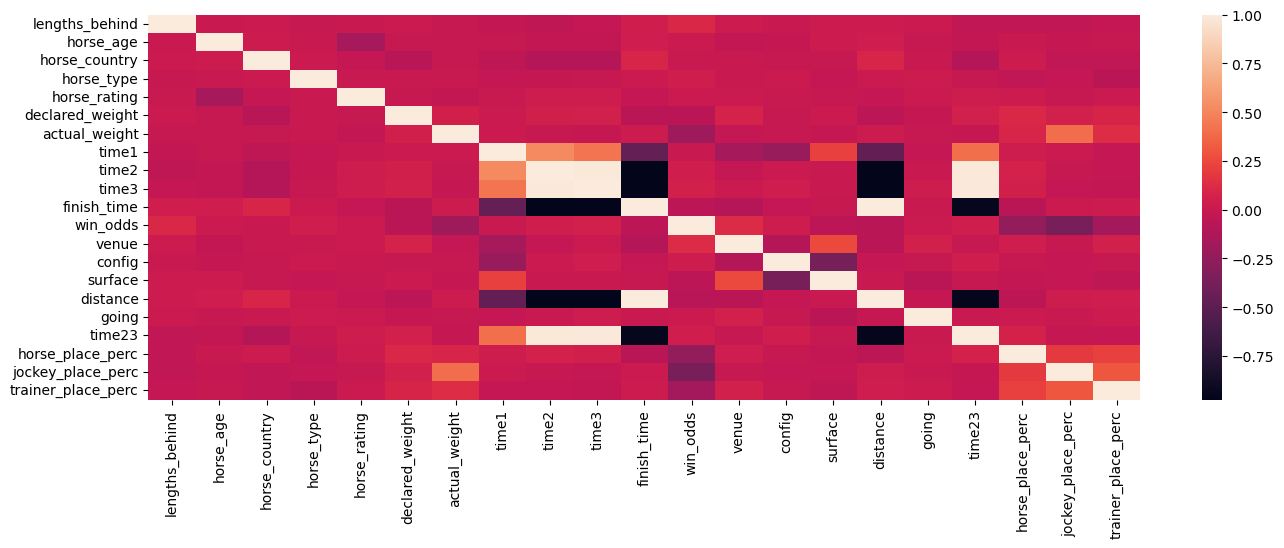

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
sns.heatmap(df.corr())

# columns

finish_time	

actual_weight	

config	

declared_weight	

distance	

going	

horse_age	

horse_country	

horse_place_perc	

horse_type	

jockey_place_perc	

time1/finising_time

time2/finising_time

time3/finising_time

surface	

trainer_place_perc	

venue

quartile = result / # horses ....

_______

result & race_id

exploratory data visualization, want both uni and multivariate visualizations for analysis

more data preprocessing and cleanning

experiment with feature selection techniques

show variety of algorithms, log reg, knn, decision trees, rand forrests, ensemble techniques, SVMs (all doable with scikit learn) build NN and DNN to expieriment with different architecture of NNs, maybe take a representative sample of 20000 or so examples (carful not to lose too much info)

meet as team ASAP and make final plan 

